In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 100em; }</style>"))
import ipywidgets as widgets

import sys
import os
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.insert(0, parent_dir)

import open3d as o3d
import numpy as np
import pickle as pkl
import json
import copy
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F

import lib.utils.etw_pytorch_utils as pt_utils
from lib.pointnet2_utils.pointnet2_modules import PointnetFPModule, PointnetSAModuleMSG
from lib.Semantic_Segmentation import SemanticSegmentation
from lib.Dense_Semantic_Segmentation import DenseSemanticSegmentation

from lib.custom_dataloader import Dataset
from lib.seg_utils import plot_graphs, FocalLoss,create_scheduler
from lib.seg_utils import dpt_2_cld,draw_p2ds,project_p3d
from lib.custom_dataloader import Dataset

from tqdm.notebook import tqdm as tqdm_notebook

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [1]:
# TODO : Write error handlers if the sampled data and features nore calculated

## Training Pointnet only


In [ ]:
# Nema17=1 sun_gear=2 housing=3 carrier=4 cover=5
class_weights = torch.tensor([1.0, 2.0, 10.0, 2.0, 2.0, 2.0])
alpha_values = [0.005, 0.095, 0.6, 0.05,0.2,0.05]

root_path = "/media/kulunu/Elements SE/Datasets/Nema17_reducer_dataset"
scene_id =  "stage_1"
dataset = Dataset(root_path,scene_id) 


num_epochs = 1
in_channels = 6
n_classes = 6
batch_size = 4
validation_split = 0.2
shuffle_dataset = True
random_seed = 42
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
save_interval = 25 


def worker_init_fn(worker_id):
    np.random.seed(np.random.get_state()[1][0] + worker_id)

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=False, sampler=train_sampler,
    num_workers=60, worker_init_fn=worker_init_fn)

#val_ds = Adapt_Dataset('val', scene_id=3)
val_loader = torch.utils.data.DataLoader(
    dataset, batch_size= batch_size, shuffle=False,sampler=valid_sampler,
    num_workers=10)

model = SemanticSegmentation(input_channels=in_channels, num_classes=n_classes)

#criterion = nn.CrossEntropyLoss()
#criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
criterion = FocalLoss(alpha=None, gamma=2)


optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = create_scheduler(optimizer, mode='step', step_size=10, gamma=0.5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop with cross-validation
for epoch in range(num_epochs):
    print("Epoch:", epoch + 1)
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Training phase
    for i, batch in enumerate(tqdm_notebook(train_loader)):
        labels, cld_rgb_nrm, _, _ = batch
        cld_rgb_nrm, labels = cld_rgb_nrm.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(cld_rgb_nrm)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        _, predicted_train = torch.max(outputs, 1)
        mask = labels != 0
        total_train +=  mask.sum().item()
        correct_train += (predicted_train[mask] == labels[mask]).sum().item()
        
    print('Training Loss:', train_loss / len(train_loader))
    train_losses.append(train_loss / len(train_loader))
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for i, batch in enumerate(tqdm_notebook(val_loader)):
            labels, cld_rgb_nrm, _,_ = batch
            choose = labels
            cld_rgb_nrm, labels = cld_rgb_nrm.to(device), labels.to(device)

            outputs = model(cld_rgb_nrm)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            
            
            # lots of zeros in training data, therefore accuracy is high/biased
            #total += labels.size(0) * labels.size(1) 
            #correct += (predicted == labels).sum().item()
            
            # above problem is fixed by removing labels corresponding to zero
            # when claculating validation accuracy
            mask = labels != 0
            correct_val += (predicted[mask] == labels[mask]).sum().item()
            total_val += mask.sum().item()
    
    val_losses.append(val_loss / len(val_loader))
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
   
    print('Validation Loss:', val_loss / len(val_loader))
    print('Validation Accuracy:', correct_val / total_val)
    
    scheduler.step()
    
    fn =  f"semantic_segmentation_model_FlossW_a1_epoch_{epoch+1}"
    
    #plot_graphs(train_losses, val_losses, train_accuracies, val_accuracies, epoch, fn)
    
    if (epoch + 1) % save_interval == 0:
        torch.save(model.state_dict(), os.path.join("checkpoints",fn) +".pt")

np.save(os.path.join("checkpoints","train_losses.npy"), train_losses)
np.save(os.path.join("checkpoints","val_losses.npy"), val_losses)
np.save(os.path.join("checkpoints","train_acc.npy"), train_accuracies)
np.save(os.path.join("checkpoints","val_acc.npy"), val_accuracies)

print('Finished Training')

## Training PVN3D Segmentation Module

In [ ]:
root_path = "/media/kulunu/Elements SE/Datasets/Nema17_reducer_dataset"
scene_id =  "stage_1"
dataset = Dataset(root_path,scene_id) 

model = DenseSemanticSegmentation(input_channels=6, num_classes=6)

num_epochs = 50
in_channels = 6
n_classes = 6
batch_size = 1
validation_split = 0.2
shuffle_dataset = True
random_seed = 42
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
save_interval = 25 


def worker_init_fn(worker_id):
    np.random.seed(np.random.get_state()[1][0] + worker_id)

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=False, sampler=train_sampler,
    num_workers=60, worker_init_fn=worker_init_fn)

#val_ds = Adapt_Dataset('val', scene_id=3)
val_loader = torch.utils.data.DataLoader(
    dataset, batch_size= batch_size, shuffle=False,sampler=valid_sampler,
    num_workers=10)

#criterion = nn.CrossEntropyLoss()
#criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
criterion = FocalLoss(alpha=None, gamma=2)


optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = create_scheduler(optimizer, mode='step', step_size=10, gamma=0.5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop with cross-validation
for epoch in range(num_epochs):
    print("Epoch:", epoch + 1)
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Training phase
    for i, batch in enumerate(tqdm_notebook(train_loader)):
        labels, cld_rgb_nrm, choose, rgb = batch
        cld_rgb_nrm, labels = cld_rgb_nrm.to(device), labels.to(device)
        choose, rgb = choose.to(device), rgb.to(device)
        
        optimizer.zero_grad()
        outputs = model(cld_rgb_nrm,rgb,choose)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        _, predicted_train = torch.max(outputs, 1)
        mask = labels != 0
        total_train +=  mask.sum().item()
        correct_train += (predicted_train[mask] == labels[mask]).sum().item()
        
    print('Training Loss:', train_loss / len(train_loader))
    train_losses.append(train_loss / len(train_loader))
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for i, batch in enumerate(tqdm_notebook(val_loader)):
            labels, cld_rgb_nrm, choose, rgb = batch
            cld_rgb_nrm, labels = cld_rgb_nrm.to(device), labels.to(device)
            choose, rgb = choose.to(device), rgb.to(device)
        
            outputs = model(cld_rgb_nrm)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            
            
            # lots of zeros in training data, therefore accuracy is high/biased
            #total += labels.size(0) * labels.size(1) 
            #correct += (predicted == labels).sum().item()
            
            # above problem is fixed by removing labels corresponding to zero
            # when claculating validation accuracy
            mask = labels != 0
            correct_val += (predicted[mask] == labels[mask]).sum().item()
            total_val += mask.sum().item()
    
    val_losses.append(val_loss / len(val_loader))
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
   
    print('Validation Loss:', val_loss / len(val_loader))
    print('Validation Accuracy:', correct_val / total_val)
    
    scheduler.step()
    
    fn =  f"semantic_segmentation_model_FlossW_a1_epoch_{epoch+1}"
    
    plot_graphs(train_losses, val_losses, train_accuracies, val_accuracies, epoch, fn)
    
    if (epoch + 1) % save_interval == 0:
        torch.save(model.state_dict(), os.path.join("checkpoints",fn) +".pt")

print('Finished Training')


## Testing


### Testing for pointnet only model

checkpoint loaded!
preds, tensor([0, 1, 3, 5], device='cuda:0')
labels tensor([0, 1, 2, 3, 4, 5], device='cuda:0')
accuracy : 12288 11582 0.9425455729166666


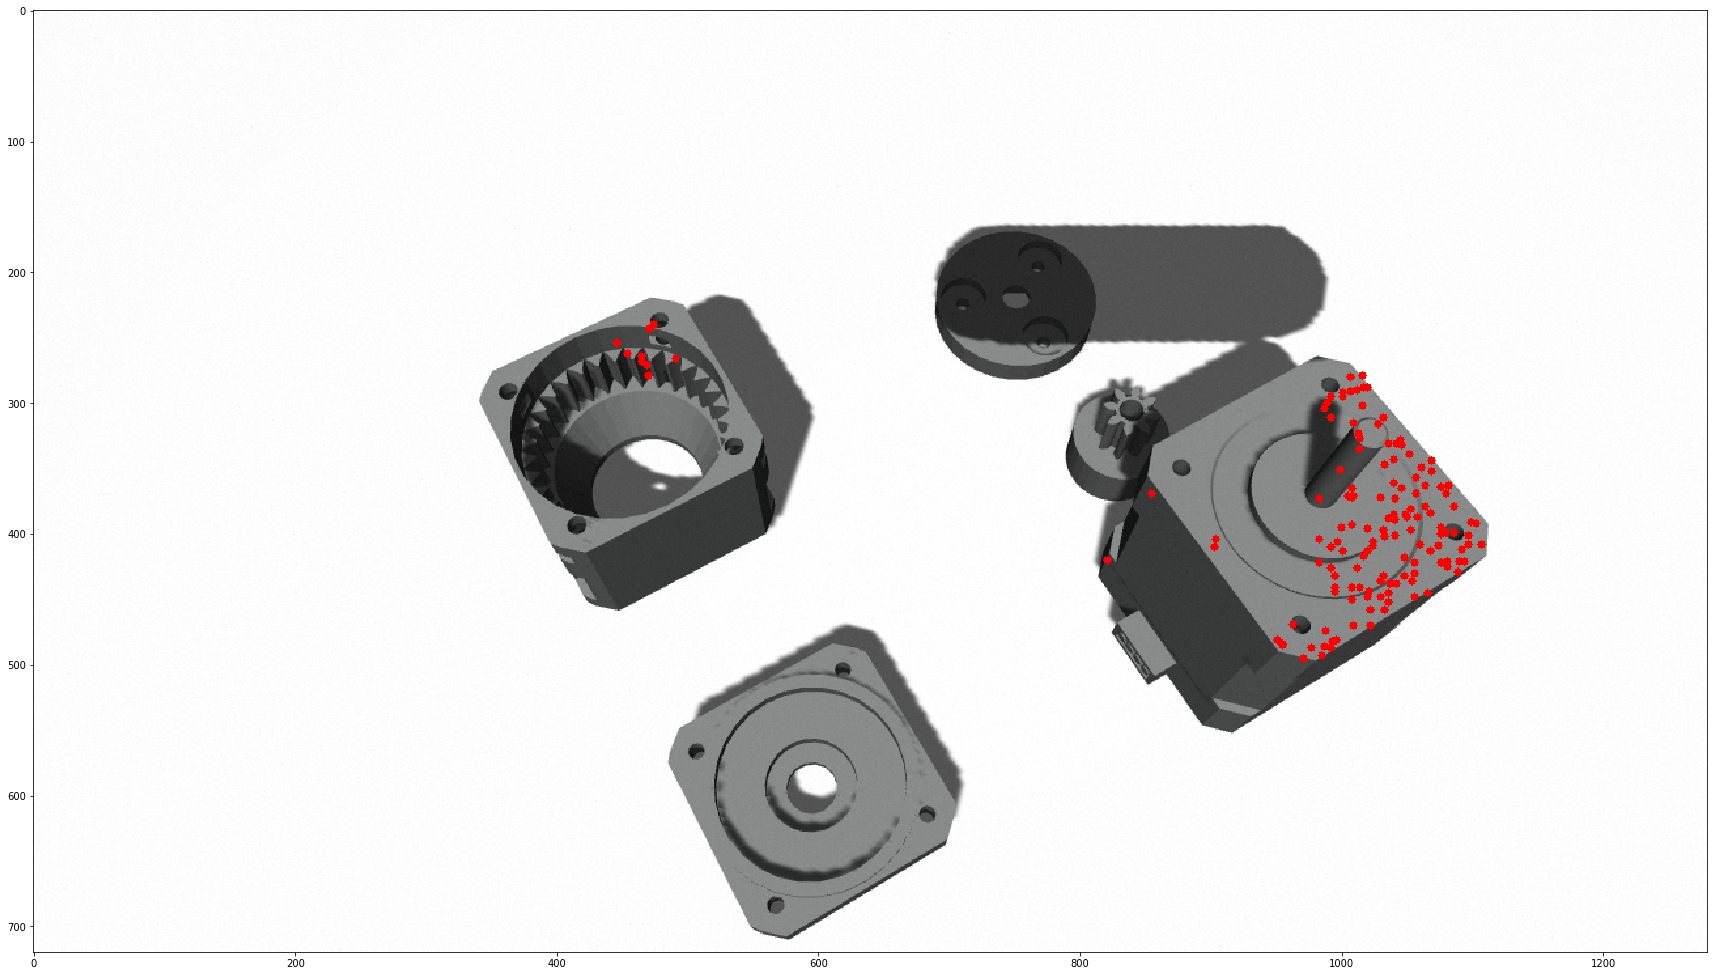

In [5]:

root_path = "/media/kulunu/Elements SE/Datasets/Nema17_reducer_dataset"
scene_id =  "stage_1"
dataset = Dataset(root_path,scene_id) 


idx = 70
data_torch = dataset.get_item(idx=idx)
model = SemanticSegmentation(input_channels=6, num_classes=6)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

total = 0
correct = 0

try:
    checkpoint = torch.load(os.path.join(parent_dir,"checkpoints","semantic_segmentation_model_FlossW_a1_epoch_50.pt"))
    model.load_state_dict(checkpoint)
    model.eval()
    print("checkpoint loaded!")
 
except:
    print("checkpoint load failed!")


with torch.set_grad_enabled(False):
    cu_dt = [item.contiguous().to("cuda", non_blocking=True) for item in data_torch]
    labels, cld_rgb_nrm, choose, rgb  = cu_dt

    cld_rgb_nrm, labels = cld_rgb_nrm.to(device), labels.to(device)
    
    cld_rgb_nrm = cld_rgb_nrm.unsqueeze(0)
    
    outputs = model(cld_rgb_nrm)
    _, predictions = torch.max(outputs, 1)
    
    print("preds,", torch.unique(predictions))
    print("labels", torch.unique(labels))

    
    total = labels.size(0)
    correct = (predictions == labels).sum().item()
    
    print("accuracy :", total, correct, correct / total)
    

# convert tensors back to numpies    
predictions = predictions.squeeze().cpu().numpy()
pcld = cld_rgb_nrm.squeeze().cpu().numpy()[:,0:3]
labels = labels.squeeze().cpu().numpy()
rgb = rgb.cpu().numpy().transpose(1, 2, 0)[...,::-1].copy()


K,dpt_K, cam_scale = dataset.get_cam_info(idx=idx)


#Nema17=1 sun_gear=2 housing=3 carrier=4 cover=5
#color = [(255,255,255),(255,0,0),(155,155,0),(0,255,255),(255,255,0), (115,10,0)]

color = (255,0,0)

for i in np.unique(predictions):
    if i == 1:
        p2ds = project_p3d(pcld[predictions == i], cam_scale, K)
        rgb = draw_p2ds(rgb, p2ds,color,3)

plt.figure(figsize=(30,30))
plt.imshow(np.asarray(rgb,np.int32),interpolation='none')
plt.show()   


### Testing for pvn3d segmentation module

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to lib/ResNet_pretrained_mdl/resnet34-333f7ec4.pth


loading pretrained mdl.


87306240it [00:07, 11723697.68it/s]


checkpoint loaded!
preds, tensor([0, 1, 3], device='cuda:0')
labels tensor([0, 1, 2, 3, 4, 5], device='cuda:0')
accuracy : 12288 11455 0.9322102864583334


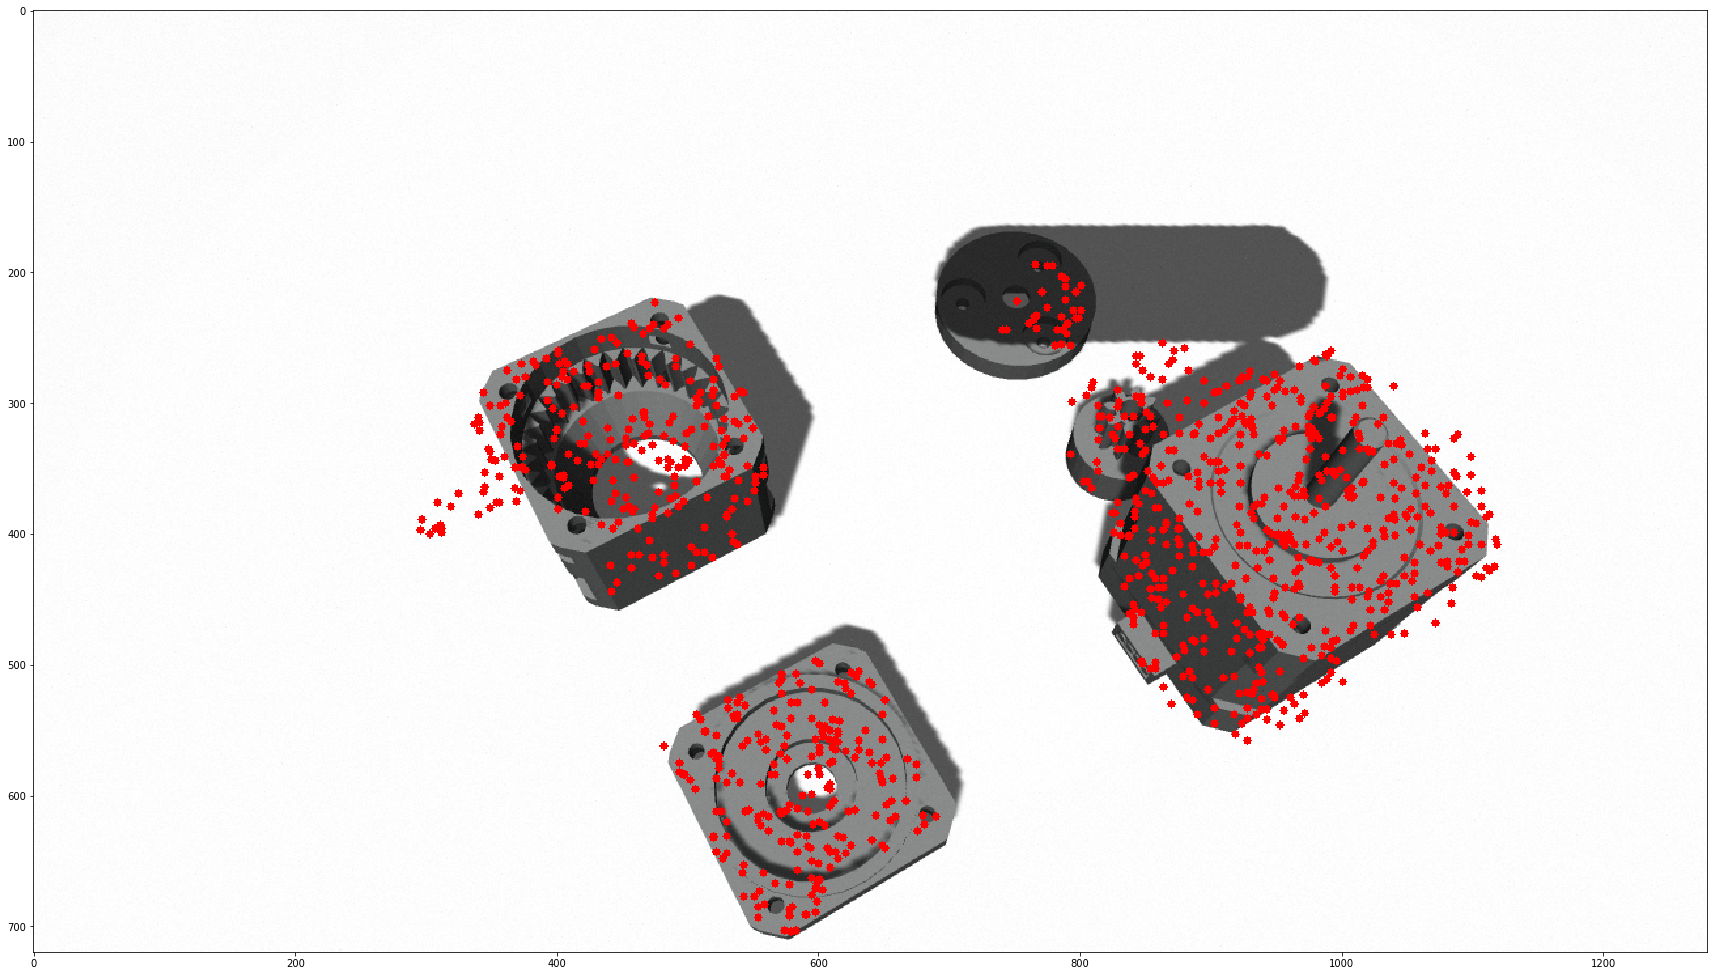

In [4]:
root_path = "/media/kulunu/Elements SE/Datasets/Nema17_reducer_dataset"
scene_id =  "stage_1"
dataset = Dataset(root_path,scene_id) 


idx = 70
data_torch = dataset.get_item(idx=idx)
model = DenseSemanticSegmentation(input_channels=6, num_classes=6)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = FocalLoss(alpha=None, gamma=2)

model.to(device)
model = nn.DataParallel(model)


total = 0
correct = 0

try:
    checkpoint = torch.load(os.path.join(parent_dir,"checkpoints","Dense_semantic_segmentation_model_FlossW_a1_batch16_epoch_50.pt"))
    model.load_state_dict(checkpoint)
    model.eval()
    print("checkpoint loaded!")
 
except:
    print("checkpoint load failed!")


with torch.set_grad_enabled(False):
    cu_dt = [item.contiguous().to("cuda", non_blocking=True) for item in data_torch]
    
    labels, cld_rgb_nrm, choose, rgb  = cu_dt
    cld_rgb_nrm, labels = cld_rgb_nrm.to(device), labels.to(device)
    choose, rgb = choose.to(device), rgb.to(device)

    outputs = model(cld_rgb_nrm.unsqueeze(0),rgb.unsqueeze(0),choose.unsqueeze(0))

    outputs = outputs.view(labels.numel(), -1)
    labels = labels.view(-1)

    loss = criterion(outputs, labels)

    _, predictions = torch.max(outputs, 1)

    print("preds,", torch.unique(predictions))
    print("labels", torch.unique(labels))
    
    total = labels.size(0)
    correct = (predictions == labels).sum().item()
    print("accuracy :", total, correct, correct / total)
    
# convert tensors to numpies  
predictions = predictions.squeeze().cpu().numpy()
pcld = cld_rgb_nrm.squeeze().cpu().numpy()[:,0:3]
labels = labels.squeeze().cpu().numpy()
rgb = rgb.cpu().numpy().transpose(1, 2, 0)[...,::-1].copy()

K,dpt_K, cam_scale = dataset.get_cam_info(idx=idx)

#Nema17=1 sun_gear=2 housing=3 carrier=4 cover=5
#color = [(255,255,255),(255,0,0),(155,155,0),(0,255,255),(255,255,0), (115,10,0)]
color = (255,0,0)

for i in np.unique(predictions):
    if i == 1:
        p2ds = project_p3d(pcld[predictions == i], cam_scale, K)
        rgb = draw_p2ds(rgb, p2ds,color,3)
    
plt.figure(figsize=(30,30))
plt.imshow(np.asarray(rgb,np.int32),interpolation='none')
plt.show() 
del model        
torch.cuda.empty_cache()  